Testing N=8: 100%|██████████| 100/100 [00:09<00:00, 10.53it/s]


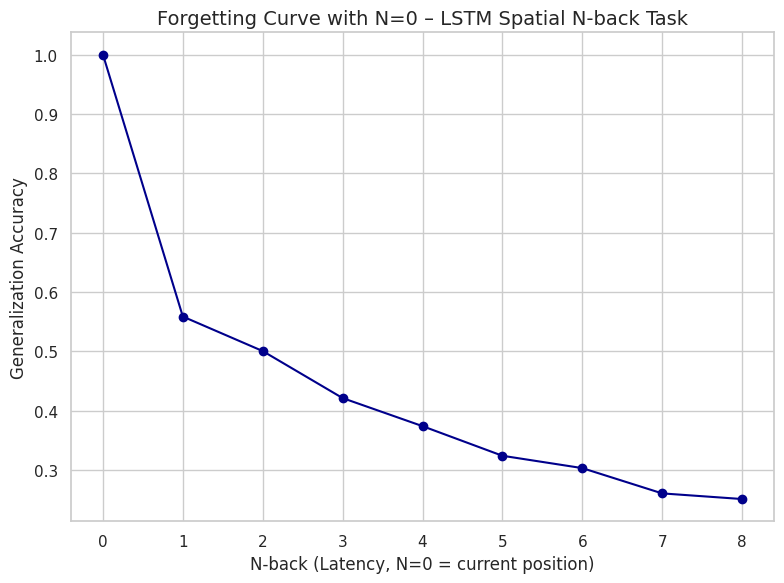

In [9]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import trange

# Configuration
GRID_SIZE = 5
HIDDEN_SIZE = 64
INPUT_SIZE = GRID_SIZE**2 + 4
OUTPUT_SIZE = GRID_SIZE**2
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
QUERY_PROB = 0.3
MAX_STEPS = 200
DROPOUT_RATE = 0.2


class MemoryLSTM(nn.Module):
    """LSTM-based model for spatial N-back task."""
    def __init__(self, input_size: int, hidden_size: int, output_size: int, dropout: float = 0.2):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x: torch.Tensor, h):
        out, h = self.lstm(x.unsqueeze(1), h)
        out = self.dropout(out)
        return self.fc(out.squeeze(1)), h


def pos_to_onehot(pos: tuple[int, int], grid_size: int) -> np.ndarray:
    onehot = np.zeros(grid_size * grid_size)
    onehot[pos[0] * grid_size + pos[1]] = 1
    return onehot

def action_to_onehot(action: int) -> np.ndarray:
    onehot = np.zeros(4)
    onehot[action] = 1
    return onehot

def move(pos: tuple[int, int], action: int, grid_size: int) -> tuple[int, int]:
    x, y = pos
    if action == 0 and x > 0: x -= 1
    elif action == 1 and x < grid_size - 1: x += 1
    elif action == 2 and y > 0: y -= 1
    elif action == 3 and y < grid_size - 1: y += 1
    return (x, y)


class MemoryAgent:
    def __init__(self, N: int, grid_size: int = GRID_SIZE, hidden_size: int = HIDDEN_SIZE):
        self.N = N
        self.grid_size = grid_size
        self.model = MemoryLSTM(INPUT_SIZE, hidden_size, OUTPUT_SIZE, dropout=DROPOUT_RATE).to(DEVICE)
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.0001)
        self.criterion = nn.CrossEntropyLoss()

    def train(self, episodes: int = 500):
        self.model.train()
        for _ in trange(episodes, desc=f"Training N={self.N}"):
            pos = (np.random.randint(self.grid_size), np.random.randint(self.grid_size))
            history = deque(maxlen=self.N + 1)
            h = (torch.zeros(1, 1, HIDDEN_SIZE, device=DEVICE), torch.zeros(1, 1, HIDDEN_SIZE, device=DEVICE))

            for _ in range(MAX_STEPS):
                action = np.random.choice(4)
                next_pos = move(pos, action, self.grid_size)
                input_vec = np.concatenate([pos_to_onehot(pos, self.grid_size), action_to_onehot(action)])
                input_tensor = torch.FloatTensor(input_vec).unsqueeze(0).to(DEVICE)

                logits, h = self.model(input_tensor, (h[0].detach(), h[1].detach()))
                history.append(pos)
                pos = next_pos

                if len(history) > self.N and random.random() < QUERY_PROB:
                    target = history[-(self.N + 1)] if self.N > 0 else history[-1]
                    target_idx = target[0] * self.grid_size + target[1]
                    target_tensor = torch.LongTensor([target_idx]).to(DEVICE)

                    loss = self.criterion(logits, target_tensor)
                    self.optimizer.zero_grad()
                    loss.backward()
                    self.optimizer.step()

    def evaluate(self, episodes: int = 100) -> float:
        self.model.eval()
        correct, total = 0, 0

        with torch.no_grad():
            for _ in trange(episodes, desc=f"Testing N={self.N}"):
                pos = (np.random.randint(self.grid_size), np.random.randint(self.grid_size))
                history = deque(maxlen=self.N + 1)
                h = (torch.zeros(1, 1, HIDDEN_SIZE, device=DEVICE), torch.zeros(1, 1, HIDDEN_SIZE, device=DEVICE))

                for _ in range(MAX_STEPS):
                    action = np.random.choice(4)
                    next_pos = move(pos, action, self.grid_size)
                    input_vec = np.concatenate([pos_to_onehot(pos, self.grid_size), action_to_onehot(action)])
                    input_tensor = torch.FloatTensor(input_vec).unsqueeze(0).to(DEVICE)

                    logits, h = self.model(input_tensor, h)
                    history.append(pos)
                    pos = next_pos

                    if len(history) > self.N and random.random() < QUERY_PROB:
                        target = history[-(self.N + 1)] if self.N > 0 else history[-1]
                        target_idx = target[0] * self.grid_size + target[1]
                        pred_idx = torch.argmax(logits).item()
                        correct += (pred_idx == target_idx)
                        total += 1
        return correct / total if total > 0 else 0


def run_memory_experiment(max_n: int = 8) -> list[float]:
    accuracies = []
    agent = MemoryAgent(N=0)
    agent.train()
    acc = agent.evaluate()
    accuracies.append(acc)

    for N in range(1, max_n + 1):
        agent.N = N
        agent.train()
        acc = agent.evaluate()
        accuracies.append(acc)
    return accuracies


def plot_results(forgetting_curve: list[float]):
    sns.set(style="whitegrid")
    plt.figure(figsize=(8, 6))
    plt.plot(range(0, len(forgetting_curve)), forgetting_curve, marker='o', color='darkblue')
    plt.title("Forgetting Curve with N=0 – LSTM Spatial N-back Task", fontsize=14)
    plt.xlabel("N-back (Latency, N=0 = current position)", fontsize=12)
    plt.ylabel("Generalization Accuracy", fontsize=12)
    plt.xticks(range(0, len(forgetting_curve)))
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    curve = run_memory_experiment()
    plot_results(curve)
